## testQM9

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import QM9
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv, TopKPooling
from torch_geometric.transforms import ToUndirected
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 加载数据集

In [3]:
# === SinCos 位置编码 ===
def sinusoidal_index_pe(num_nodes, dim):
    pe = torch.zeros(num_nodes, dim)
    position = torch.arange(0, num_nodes).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim, 2) * -(np.log(10000.0) / dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

In [7]:
# === Encoder ===
class GCNEncoderWithPool(nn.Module):
    def __init__(self, in_dim, pe_dim, hidden_dim, latent_dim, pool_ratio=0.5):
        super().__init__()
        self.gc1 = GCNConv(in_dim + pe_dim, hidden_dim)
        self.gc_mu = GCNConv(hidden_dim, latent_dim)
        self.gc_logvar = GCNConv(hidden_dim, latent_dim)
        self.pool = TopKPooling(latent_dim, ratio=pool_ratio)

    def forward(self, x_raw, sincos_pe, edge_index):
        x_in = torch.cat([x_raw, sincos_pe], dim=-1)
        h = F.relu(self.gc1(x_in, edge_index))
        mu = self.gc_mu(h, edge_index)
        logvar = self.gc_logvar(h, edge_index)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        z_pool, edge_index_pool, _, batch, perm, score = self.pool(z, edge_index, None, batch=None)
        return z_pool, mu, logvar

In [8]:
# === Transformer Decoder + Pairwise MLP ===
class TransformerDecoderCross(nn.Module):
    def __init__(self, latent_dim, pe_dim=8, num_heads=4, num_layers=2, feat_dim=11):
        super().__init__()
        self.input_proj = nn.Linear(pe_dim + feat_dim, latent_dim)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=latent_dim,
            nhead=num_heads,
            dim_feedforward=latent_dim * 2,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.edge_mlp = nn.Sequential(
            nn.Linear(latent_dim * 2, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, mask_nodes, sincos_pe, h_pool):
        kv = h_pool.unsqueeze(0)
        q_dec = torch.cat([mask_nodes, sincos_pe], dim=-1)
        q_proj = self.input_proj(q_dec).unsqueeze(0)
        h_dec = self.decoder(q_proj, kv).squeeze(0)

        N = h_dec.size(0)
        edge_prob = torch.zeros(N, N)
        for i in range(N):
            for j in range(N):
                if i == j:
                    edge_prob[i, j] = 0.0
                else:
                    edge_prob[i, j] = self.edge_mlp(torch.cat([h_dec[i], h_dec[j]], dim=-1))
        return edge_prob

In [9]:
# === GraphVAE + Pool ===
class GraphVAEPooled(nn.Module):
    def __init__(self, feat_dim, pe_dim, hidden_dim, latent_dim, pool_ratio=0.5):
        super().__init__()
        self.encoder = GCNEncoderWithPool(feat_dim, pe_dim, hidden_dim, latent_dim, pool_ratio)
        self.decoder = TransformerDecoderCross(latent_dim, pe_dim=pe_dim, feat_dim=feat_dim)

    def forward(self, x_raw, edge_index, sincos_pe):
        h_pool, mu, logvar = self.encoder(x_raw, sincos_pe, edge_index)
        mask_nodes = torch.zeros_like(x_raw)
        edge_prob = self.decoder(mask_nodes, sincos_pe, h_pool)
        return edge_prob, mu, logvar

In [10]:
# === 损失函数 ===
def graph_vae_loss(A_pred, A_gt, mu, logvar):
    recon = F.binary_cross_entropy(A_pred.view(-1), A_gt.view(-1))
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl

In [11]:
# === 可视化 ===
def visualize_gt_vs_pred(adj_gt, edge_pred_bin):
    G_gt = nx.from_numpy_array(adj_gt.numpy())
    G_pred = nx.from_numpy_array(edge_pred_bin.numpy())
    pos = nx.spring_layout(G_gt, seed=42)
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    nx.draw(G_gt, pos, with_labels=True, node_color='skyblue', edge_color='green')
    plt.title("Ground Truth")
    plt.subplot(1,2,2)
    nx.draw(G_pred, pos, with_labels=True, node_color='orange', edge_color='red')
    plt.title("Predicted Graph")
    plt.show()

In [16]:
# === 主流程 ===
if __name__ == "__main__":
    # 加载一个图 10000 7777 9580
    dataset = QM9(root='data/QM9')
    data = dataset[765]
    x_raw = data.x
    edge_index = data.edge_index
    adj_gt = to_dense_adj(edge_index)[0]
    sincos_pe = sinusoidal_index_pe(x_raw.size(0), dim=8)

    # 初始化模型
    model = GraphVAEPooled(feat_dim=11, pe_dim=8, hidden_dim=32, latent_dim=32, pool_ratio=0.5)
    opt = torch.optim.Adam(model.parameters(), lr=0.005)

    # 训练
    for step in range(500):
        A_pred, mu, logvar = model(x_raw, edge_index, sincos_pe)
        loss = graph_vae_loss(A_pred, adj_gt, mu, logvar)
        opt.zero_grad()
        loss.backward()
        opt.step()
        if step % 100 == 0:
            print(f"[Step {step}] Loss: {loss.item():.4f}")

    # 预测结果
    A_pred, _, _ = model(x_raw, edge_index, sincos_pe)
    edge_pred_bin = (A_pred > 0.5).float()
    print("\nGT adjacency:\n", adj_gt)
    print("\nPred adjacency:\n", edge_pred_bin)


[Step 0] Loss: 1.4297
[Step 100] Loss: 0.0864
[Step 200] Loss: 0.0463
[Step 300] Loss: 0.0131
[Step 400] Loss: 0.0042

GT adjacency:
 tensor([[0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1.],
        [0., 1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 1., 0.]])

Pred adjacency:
 tensor([[0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1.],
        [0., 1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 1., 0., 0., 1., 0.]])


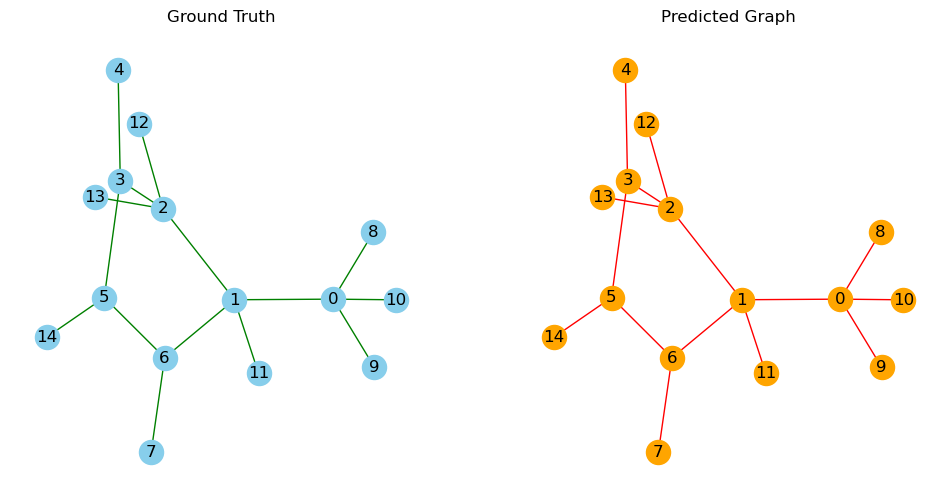

In [15]:
 # 可视化
visualize_gt_vs_pred(adj_gt, edge_pred_bin)

In [18]:
y_true = adj_gt.cpu().numpy().flatten()
y_pred = edge_pred_bin.cpu().numpy().flatten()
y_score = A_pred.detach().cpu().numpy().flatten()

# 指标计算
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true, y_score)
ap = average_precision_score(y_true, y_score)

print("\n=== Evaluation Metrics ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Average Precision (AP): {ap:.4f}")


=== Evaluation Metrics ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC-AUC: 1.0000
Average Precision (AP): 1.0000


In [4]:
import torch
print(torch.cuda.is_available())        # 是否能检测到 GPU？
print(torch.version.cuda)               # CUDA 版本
print(torch.cuda.get_device_name(0))    # GPU 名称（如果可用）


True
12.8
NVIDIA GeForce RTX 5070 Ti
